In [1]:
%matplotlib inline
import os
import glob
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
### データファイルの読込
df_mig = pd.read_csv('./data/00200523_migration.csv', parse_dates=['datetime'])
df_pop = pd.read_csv('./data/00200241_population.csv', parse_dates=['datetime'])
df_wag = pd.read_csv('./data/00450091_wage.csv', parse_dates=['datetime'])
df_idt = pd.read_csv('./data/00550010_industrial.csv', parse_dates=['datetime'])
df_ret = pd.read_csv('./data/00550020_retail.csv', parse_dates=['datetime'])
df_mig.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal
0,2005-04-01,北海道,11705,13894,52526
1,2005-04-01,青森県,4230,6603,5525
2,2005-04-01,岩手県,4082,5984,4840


In [3]:
### データの前処理(1):年次データ化
df_list = []
for prefecture in df_mig['prefecture'].unique():
    df_tmp = df_mig[df_mig['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1YS').sum()
    df_tmp.reset_index(inplace=True)
    df_tmp.insert(1, 'prefecture', prefecture)
    df_list.append(df_tmp)
df_mig_year = pd.concat(df_list)

df_pop_year = df_pop

df_wag_year = df_wag

df_list = []
for prefecture in df_idt['prefecture'].unique():
    df_tmp = df_idt[df_idt['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1YS').interpolate()
    df_tmp.reset_index(inplace=True)
    df_tmp['prefecture'] = prefecture
    df_list.append(df_tmp)
df_idt_year = pd.concat(df_list)

df_list = []
for prefecture in df_ret['prefecture'].unique():
    df_tmp = df_ret[df_ret['prefecture'] == prefecture]
    df_tmp.set_index('datetime', inplace=True)
    df_tmp = df_tmp.resample('1YS').interpolate()
    df_tmp.reset_index(inplace=True)
    df_tmp['prefecture'] = prefecture
    df_list.append(df_tmp)
df_ret_year = pd.concat(df_list)

In [4]:
### データの前処理(2):データ結合
dt_all_start = datetime.datetime.strptime('2008-01-01', '%Y-%m-%d')
dt_all_end = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d')
df_all = df_mig_year[((df_mig_year['datetime'] >= dt_all_start) & (df_mig_year['datetime'] <= dt_all_end))]
df_all = df_all.merge(df_pop_year, how='left')
df_all = df_all.merge(df_wag_year, how='left')
df_all = df_all.merge(df_idt_year, how='left')
df_all = df_all.merge(df_ret_year, how='left')
df_all.head(3)

,datetime,prefecture,mig_in,mig_out,mig_internal,pop_male,pop_female,pop_sum,pop_households,wag_age,...,wag_bonus,wag_workers,idt_offices,idt_employees,idt_salaries,idt_costs,idt_sales,ret_offices,ret_employees,ret_sales
0,2008-01-01,北海道,49497,70626,220787,2648735,2923035,5571770,2618005,41.6,...,767600,814020,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2009-01-01,北海道,51598,63776,214139,2631725,2911831,5543556,2637145,42.0,...,695700,840210,6136.0,177113.0,5.838610e+11,3.344335e+12,5.202551e+12,57847.6,460521.8,1.688161e+13
2,2010-01-01,北海道,48784,57421,205297,2618969,2901925,5520894,2654310,42.2,...,671500,748130,5931.0,173973.0,5.766830e+11,3.937932e+12,5.952864e+12,57653.4,458886.2,1.641274e+13


In [5]:
### データの前処理(3):ラグデータ化
df_list = []
for prefecture in df_idt['prefecture'].unique():
    df_tmp = df_all[df_all['prefecture'] == prefecture]
    df_tmp = df_tmp.shift(1)
    df_list.append(df_tmp)
df_all_lag1 = pd.concat(df_list)
df_all_lag1.rename(columns=lambda x: x + '_lag1', inplace=True)
df_all_lag = pd.concat([df_all.iloc[:, 0:3], df_all_lag1.iloc[:,2:24]], axis=1)
df_all_lag.dropna(inplace=True)
df_all_lag.reset_index(drop=True, inplace=True)
df_all_lag.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,...,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1
0,2009-01-01,北海道,51598,49497.0,70626.0,220787.0,2648735.0,2923035.0,5571770.0,2618005.0,...,767600.0,814020.0,6618.0,185625.0,6.255000e+11,3.893719e+12,5.917424e+12,58041.8,462157.4,1.735049e+13
1,2010-01-01,北海道,48784,51598.0,63776.0,214139.0,2631725.0,2911831.0,5543556.0,2637145.0,...,695700.0,840210.0,6136.0,177113.0,5.838610e+11,3.344335e+12,5.202551e+12,57847.6,460521.8,1.688161e+13
2,2011-01-01,北海道,51998,48784.0,57421.0,205297.0,2618969.0,2901925.0,5520894.0,2654310.0,...,671500.0,748130.0,5931.0,173973.0,5.766830e+11,3.937932e+12,5.952864e+12,57653.4,458886.2,1.641274e+13


In [6]:
### データの前処理(4):データスケーリング
df_all_list = list()
df_all_list.append(df_all_lag['datetime'])
df_all_list.append(df_all_lag['prefecture'])
df_all_list.append(df_all_lag['mig_in'])
for i in range(3, df_all_lag.shape[1]):
    sc = StandardScaler()
    a = df_all_lag.iloc[:, i]
    a = np.array(a, dtype='float32').reshape(-1, 1)
    sc.partial_fit(a)
    a = sc.transform(a)
    a = pd.DataFrame(a, columns=[df_all_lag.columns[i]])
    a = df_all_list.append(a)
df_all_sc = pd.concat(df_all_list, 1)
df_all_sc.head(3)

,datetime,prefecture,mig_in,mig_in_lag1,mig_out_lag1,mig_internal_lag1,pop_male_lag1,pop_female_lag1,pop_sum_lag1,pop_households_lag1,...,wag_bonus_lag1,wag_workers_lag1,idt_offices_lag1,idt_employees_lag1,idt_salaries_lag1,idt_costs_lag1,idt_sales_lag1,ret_offices_lag1,ret_employees_lag1,ret_sales_lag1
0,2009-01-01,北海道,51598,-0.018554,0.324887,2.103498,1.031047,1.181832,1.107231,1.216212,...,0.334509,0.635823,0.395612,0.151758,-0.116574,-0.011734,-0.047721,1.009716,0.76242,0.262148
1,2010-01-01,北海道,48784,0.011468,0.212663,2.017105,1.017830,1.173225,1.096329,1.231986,...,-0.132232,0.681597,0.287714,0.093090,-0.174385,-0.133366,-0.153472,1.002628,0.75684,0.243669
2,2011-01-01,北海道,51998,-0.028743,0.108548,1.902201,1.007919,1.165616,1.087573,1.246131,...,-0.289327,0.520663,0.241824,0.071447,-0.184351,-0.001945,-0.042478,0.995540,0.75126,0.225190


In [7]:
### データ前処理(5):学習用データ化
dt_train_start = datetime.datetime.strptime('2009-01-01', '%Y-%m-%d')
dt_train_end = datetime.datetime.strptime('2012-01-01', '%Y-%m-%d')
dt_validation_start = datetime.datetime.strptime('2013-01-01', '%Y-%m-%d')
dt_validation_end = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d')
df_train = df_all_sc[((df_all_sc['datetime'] >= dt_train_start) & (df_all_sc['datetime'] <= dt_train_end))]
df_train_rand = df_train.reindex(np.random.permutation(df_train.index)).reset_index(drop=True)
train_x = np.array(df_train_rand.iloc[:, 3:].as_matrix(), dtype='float32')
train_y = np.array(df_train_rand.iloc[:, 2].as_matrix(), dtype='float32')
df_validation = df_all_sc[((df_all_sc['datetime'] >= dt_validation_start) & (df_all_sc['datetime'] <= dt_validation_end))]
df_validation_rand = df_validation.reindex(np.random.permutation(df_validation.index)).reset_index(drop=True)
validation_x = np.array(df_validation_rand.iloc[:, 3:].as_matrix(), dtype='float32')
validation_y = np.array(df_validation_rand.iloc[:, 2].as_matrix(), dtype='float32')

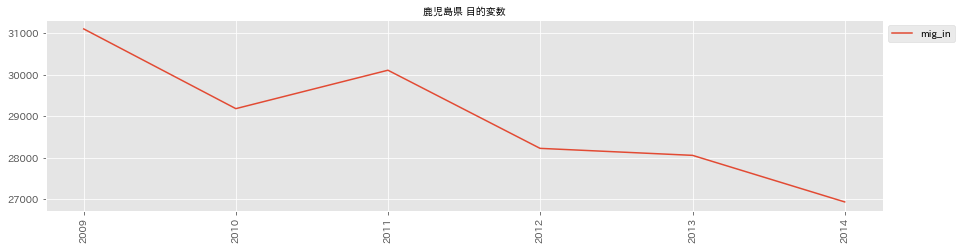

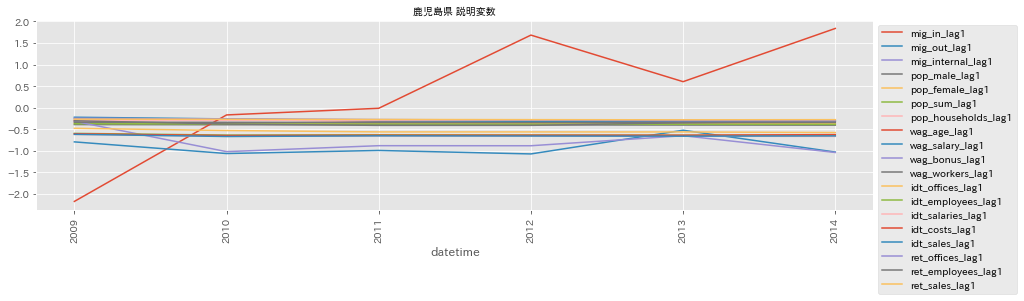

In [8]:
### 事前のデータ確認(サンプル)
prefecture = '鹿児島県'
df_tmp = df_all_sc[df_all_sc['prefecture'] == prefecture]
x = df_tmp['datetime']
y = df_tmp['mig_in']
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 目的変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

df_tmp.set_index('datetime', inplace=True)
df_tmp = df_tmp.iloc[:, 2:]
fig = plt.figure(figsize=(15,3.5))
ax = fig.add_subplot(111)
df_tmp.plot(ax=ax)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title(prefecture + ' 説明変数', fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import datasets
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [10]:
### DL学習設定
n_in = df_all_sc.shape[1] -3 # 19
n_hiddens = [200, 200]
n_out = 1
activation = 'relu'

def weight_variable(shape, name=None):
    return np.sqrt(2000.0 / shape[0]) * np.random.normal(size=shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=weight_variable))
    model.add(BatchNormalization())
    model.add(Activation(activation))

model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('relu'))
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['mae'])

### DL学習
epochs = 500
batch_size = 30
hist = model.fit(train_x, train_y, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_x, validation_y),
                 callbacks=[early_stopping])

W1004 10:15:23.862101 4583773632 deprecation_wrapper.py:119] From /Users/saka-ms/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 10:15:23.888861 4583773632 deprecation_wrapper.py:119] From /Users/saka-ms/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 10:15:23.993752 4583773632 deprecation_wrapper.py:119] From /Users/saka-ms/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1004 10:15:24.201198 4583773632 deprecation_wrapper.py:119] From /Users/saka-ms/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras/optimizers.py:7

Train on 188 samples, validate on 94 samples
Epoch 1/500
188/188 [==============================] - 1s 4ms/step - loss: 7269505274.5532 - mean_absolute_error: 50295.9480 - val_loss: 7699520201.5319 - val_mean_absolute_error: 50634.3785
Epoch 2/500
188/188 [==============================] - 0s 225us/step - loss: 7261068775.4894 - mean_absolute_error: 50264.4113 - val_loss: 7687541403.2340 - val_mean_absolute_error: 50600.4989
Epoch 3/500
188/188 [==============================] - 0s 338us/step - loss: 7251204628.4255 - mean_absolute_error: 50232.4496 - val_loss: 7677017760.6809 - val_mean_absolute_error: 50569.9553
Epoch 4/500
188/188 [==============================] - 0s 192us/step - loss: 7243467571.7447 - mean_absolute_error: 50200.6150 - val_loss: 7666739387.9149 - val_mean_absolute_error: 50541.4177
Epoch 5/500
188/188 [==============================] - 0s 239us/step - loss: 7236641691.2340 - mean_absolute_error: 50169.7664 - val_loss: 7655496684.9362 - val_mean_absolute_error: 505

188/188 [==============================] - 0s 193us/step - loss: 6622979344.3404 - mean_absolute_error: 47709.2727 - val_loss: 6964192900.0851 - val_mean_absolute_error: 48322.9099
Epoch 44/500
188/188 [==============================] - 0s 212us/step - loss: 6610007200.6809 - mean_absolute_error: 47593.5732 - val_loss: 6932050512.3404 - val_mean_absolute_error: 48198.6375
Epoch 45/500
188/188 [==============================] - 0s 234us/step - loss: 6565455014.1277 - mean_absolute_error: 47483.3752 - val_loss: 6907682008.5106 - val_mean_absolute_error: 48075.8177
Epoch 46/500
188/188 [==============================] - 0s 220us/step - loss: 6542728537.8723 - mean_absolute_error: 47367.9012 - val_loss: 6873581980.5957 - val_mean_absolute_error: 47941.7902
Epoch 47/500
188/188 [==============================] - 0s 194us/step - loss: 6537404522.2128 - mean_absolute_error: 47248.8593 - val_loss: 6840297414.8085 - val_mean_absolute_error: 47847.4270
Epoch 48/500
188/188 [=====================

188/188 [==============================] - 0s 234us/step - loss: 5359456804.7660 - mean_absolute_error: 41446.2172 - val_loss: 5474118743.1489 - val_mean_absolute_error: 41994.7935
Epoch 86/500
188/188 [==============================] - 0s 181us/step - loss: 5318763880.1702 - mean_absolute_error: 41264.7032 - val_loss: 5429437241.1915 - val_mean_absolute_error: 41767.1301
Epoch 87/500
188/188 [==============================] - 0s 158us/step - loss: 5290954199.1489 - mean_absolute_error: 41067.7024 - val_loss: 5382152134.8085 - val_mean_absolute_error: 41548.3696
Epoch 88/500
188/188 [==============================] - 0s 178us/step - loss: 5199701603.4043 - mean_absolute_error: 40872.6701 - val_loss: 5348794382.9787 - val_mean_absolute_error: 41344.8628
Epoch 89/500
188/188 [==============================] - 0s 214us/step - loss: 5150680566.4681 - mean_absolute_error: 40680.4639 - val_loss: 5312814214.8085 - val_mean_absolute_error: 41072.7789
Epoch 90/500
188/188 [=====================

188/188 [==============================] - 0s 179us/step - loss: 3708192526.6383 - mean_absolute_error: 32483.6578 - val_loss: 3850685644.9362 - val_mean_absolute_error: 33249.0050
Epoch 128/500
188/188 [==============================] - 0s 233us/step - loss: 3743243204.0851 - mean_absolute_error: 32361.8181 - val_loss: 3806828388.0851 - val_mean_absolute_error: 33186.3594
Epoch 129/500
188/188 [==============================] - 0s 205us/step - loss: 3680535369.5319 - mean_absolute_error: 32028.4592 - val_loss: 3784772388.7660 - val_mean_absolute_error: 32898.7985
Epoch 130/500
188/188 [==============================] - 0s 255us/step - loss: 3745612191.6596 - mean_absolute_error: 31811.2137 - val_loss: 3722338933.1064 - val_mean_absolute_error: 32571.5919
Epoch 131/500
188/188 [==============================] - 0s 184us/step - loss: 3823910278.4681 - mean_absolute_error: 31590.2172 - val_loss: 3693107365.4468 - val_mean_absolute_error: 32435.8632
Epoch 132/500
188/188 [================

188/188 [==============================] - 0s 219us/step - loss: 2435997008.3404 - mean_absolute_error: 23889.3968 - val_loss: 2307285199.6596 - val_mean_absolute_error: 22962.4873
Epoch 170/500
188/188 [==============================] - 0s 232us/step - loss: 2324202133.1064 - mean_absolute_error: 22839.4082 - val_loss: 2327558279.1489 - val_mean_absolute_error: 22884.8251
Epoch 171/500
188/188 [==============================] - 0s 205us/step - loss: 2325135789.7021 - mean_absolute_error: 22553.4190 - val_loss: 2309685305.5319 - val_mean_absolute_error: 22756.4869
Epoch 172/500
188/188 [==============================] - 0s 191us/step - loss: 2389950871.8936 - mean_absolute_error: 22443.1827 - val_loss: 2263917195.9149 - val_mean_absolute_error: 22483.5042
Epoch 173/500
188/188 [==============================] - 0s 202us/step - loss: 2213117300.4255 - mean_absolute_error: 22060.5176 - val_loss: 2224436803.9149 - val_mean_absolute_error: 22157.1653
Epoch 174/500
188/188 [================

188/188 [==============================] - 0s 169us/step - loss: 1734103454.7660 - mean_absolute_error: 17712.4363 - val_loss: 1408995200.0426 - val_mean_absolute_error: 16604.0958
Epoch 212/500
188/188 [==============================] - 0s 235us/step - loss: 1302570442.7234 - mean_absolute_error: 15820.9763 - val_loss: 1389036458.5745 - val_mean_absolute_error: 16504.4858
Epoch 213/500
188/188 [==============================] - 0s 257us/step - loss: 1232252926.6383 - mean_absolute_error: 16224.7678 - val_loss: 1323269382.2128 - val_mean_absolute_error: 16186.4083
Epoch 214/500
188/188 [==============================] - 0s 231us/step - loss: 1216982563.8723 - mean_absolute_error: 15425.1014 - val_loss: 1296969636.8085 - val_mean_absolute_error: 15951.7211
Epoch 215/500
188/188 [==============================] - 0s 190us/step - loss: 1721061891.4255 - mean_absolute_error: 17171.7358 - val_loss: 1284501607.4043 - val_mean_absolute_error: 15760.1198
Epoch 216/500
188/188 [================

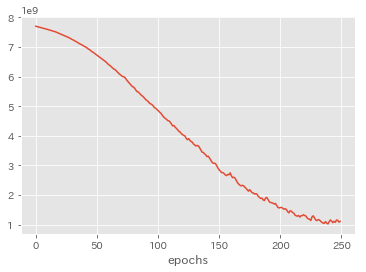

94/94 [==============================] - 0s 73us/step
[1108038814.6382978, 15950.143315741356]


In [11]:
### 学習過程の確認
val_loss = hist.history['val_loss']
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, label='loss')
plt.xlabel('epochs')
plt.show()

print(model.evaluate(validation_x, validation_y))

In [12]:
### モデルを用いた予測データの作成
train_x = np.array(df_train.iloc[:, 3:].as_matrix(), dtype='float32')
validation_x = np.array(df_validation.iloc[:, 3:].as_matrix(), dtype='float32')
pred_train = model.predict_proba(train_x) 
pred_validation = model.predict_proba(validation_x)
pred = np.concatenate([pred_train, pred_validation])
df_pred = pd.DataFrame(pred, columns=['mig_in_pred'])
df_pred = pd.concat([df_all_sc.iloc[:, 0:3], df_pred], axis=1)
df_pred.head(3)

,datetime,prefecture,mig_in,mig_in_pred
0,2009-01-01,北海道,51598,44070.257812
1,2010-01-01,北海道,48784,42989.828125
2,2011-01-01,北海道,51998,42241.703125


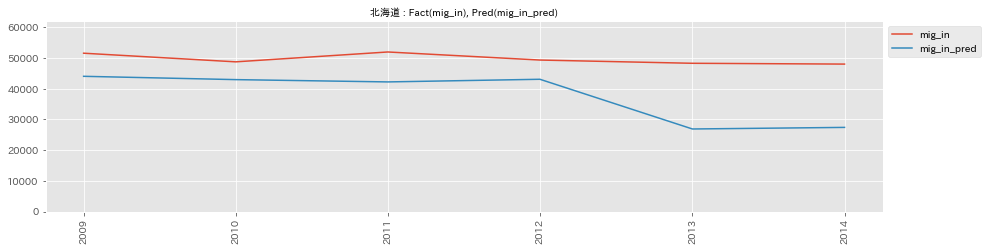

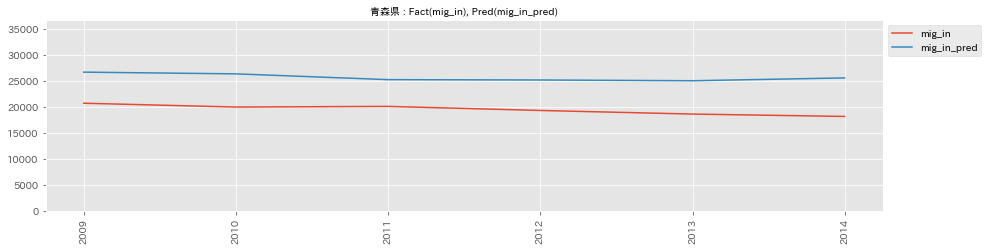

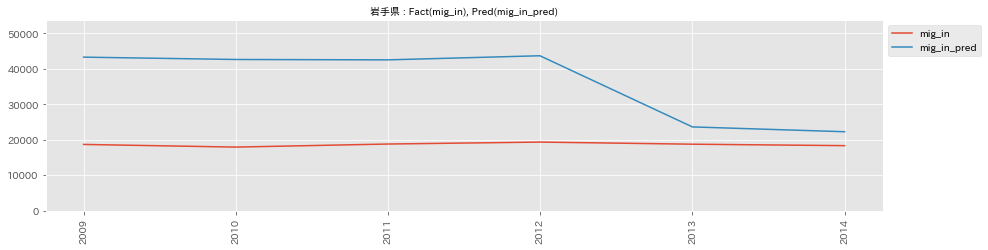

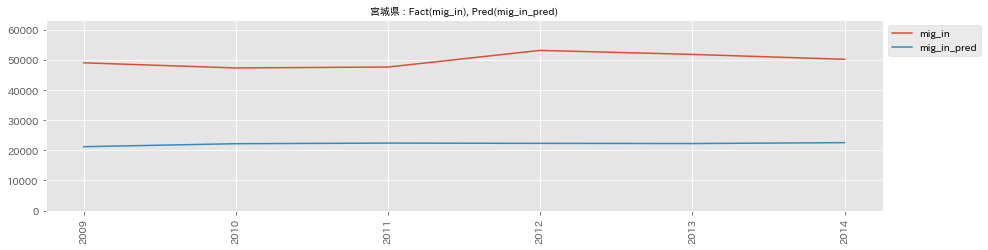

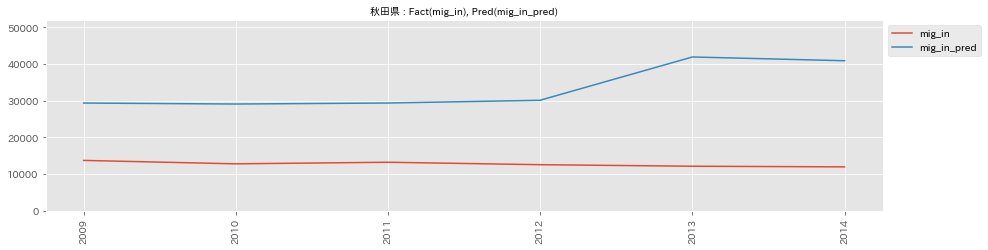

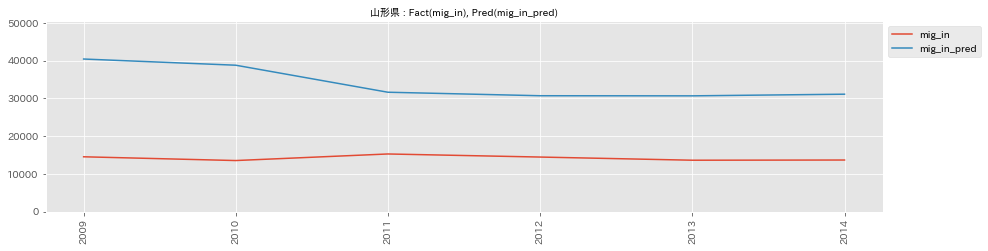

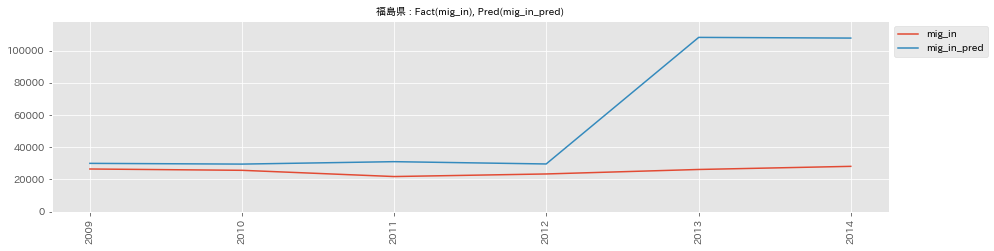

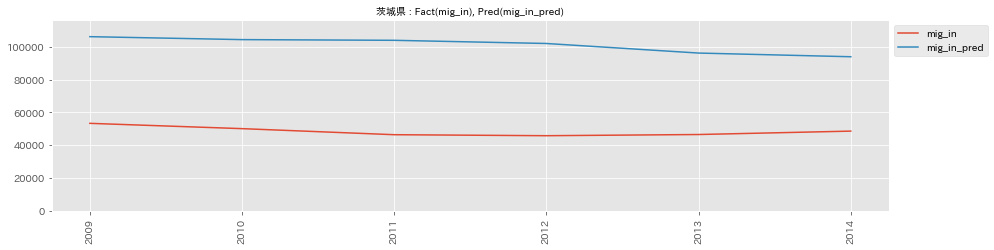

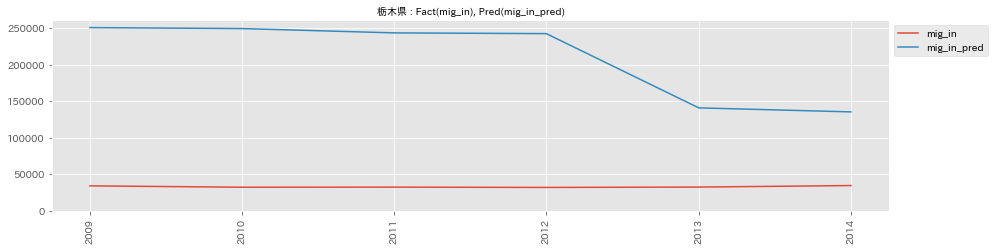

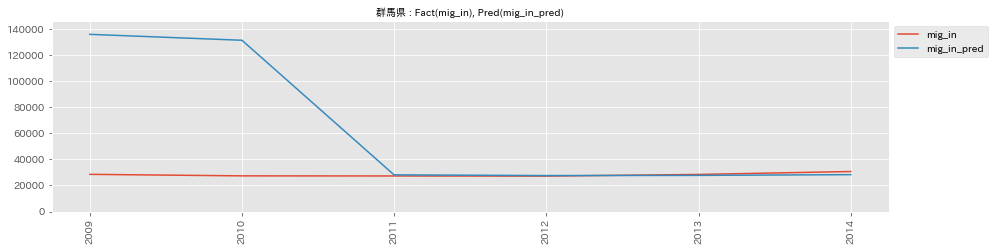

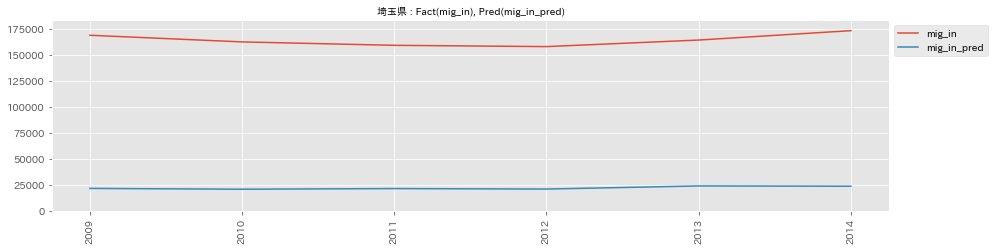

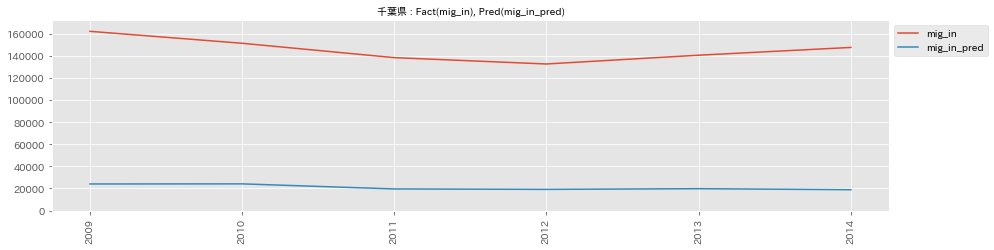

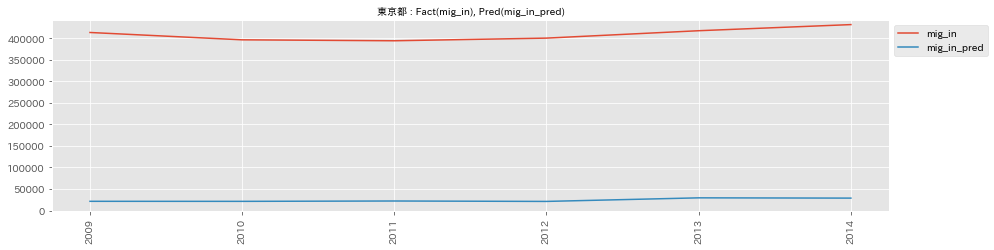

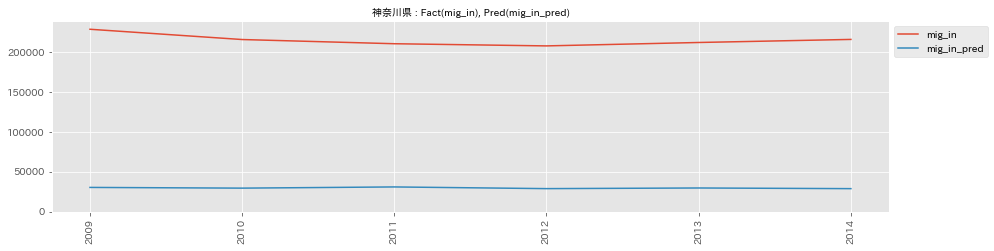

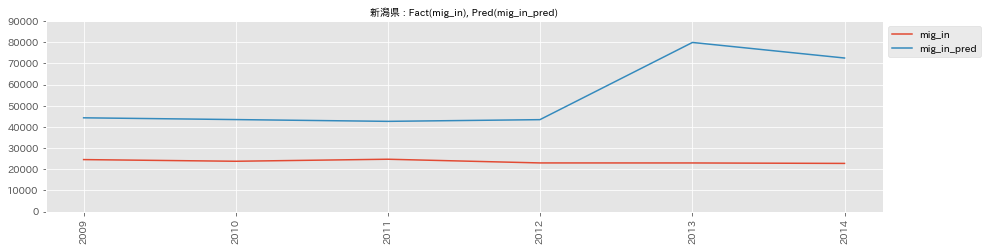

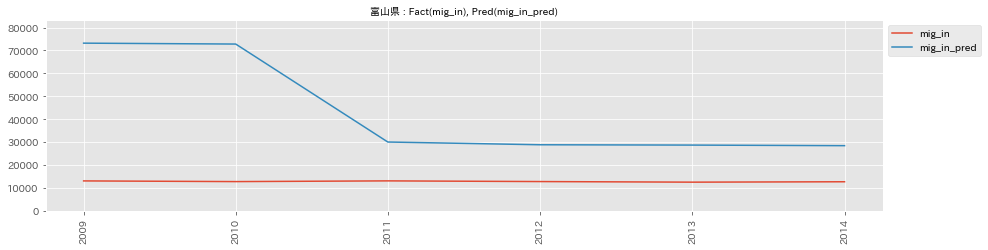

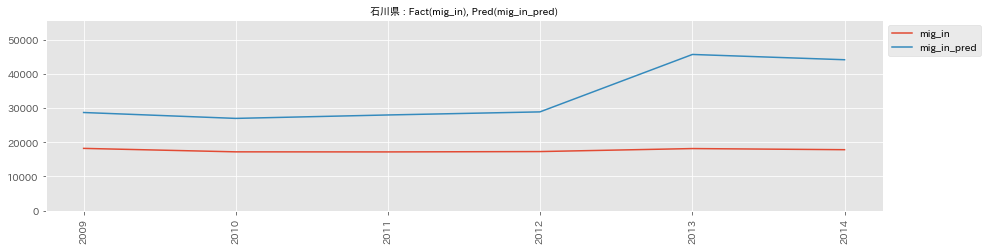

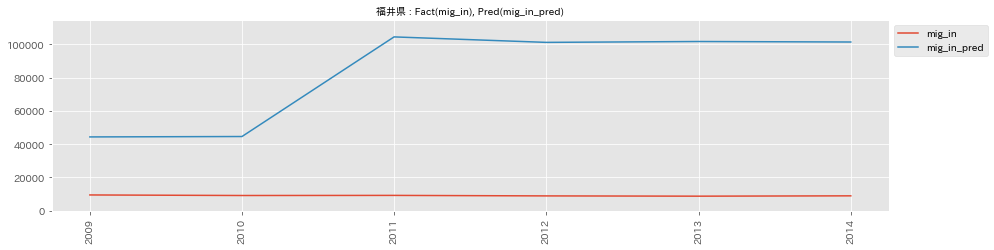

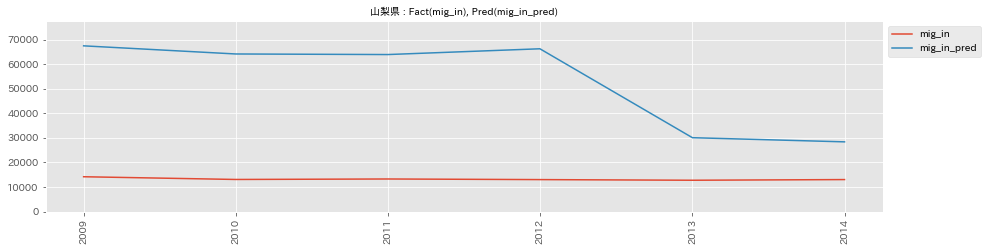

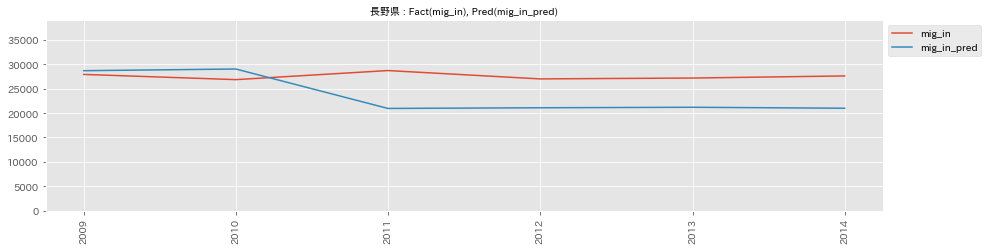

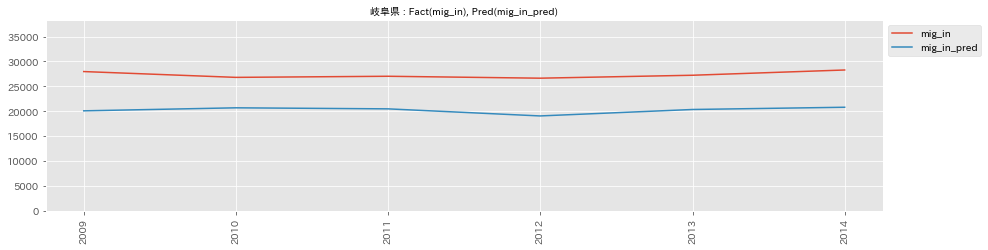

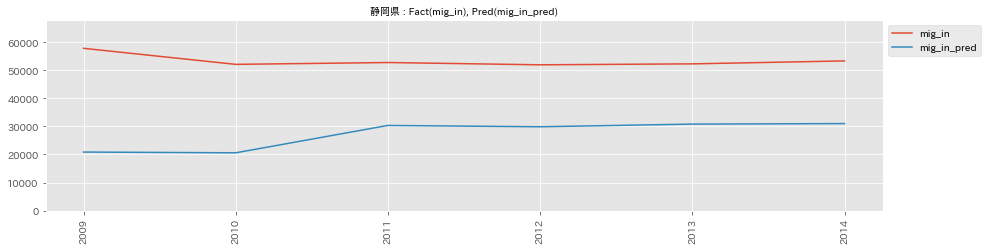

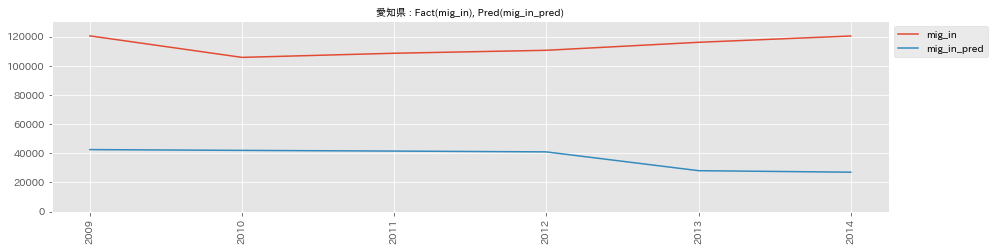

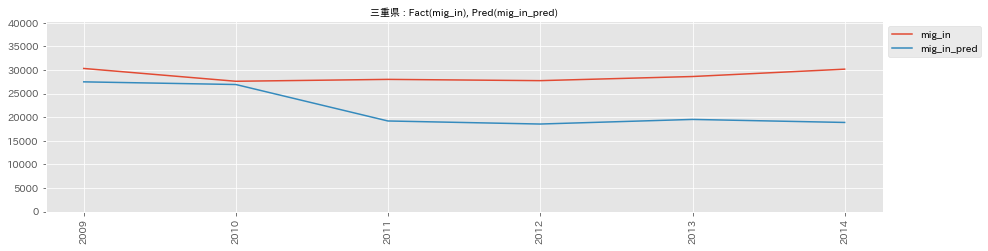

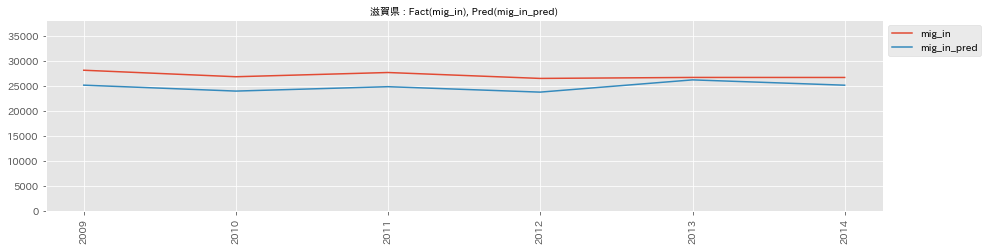

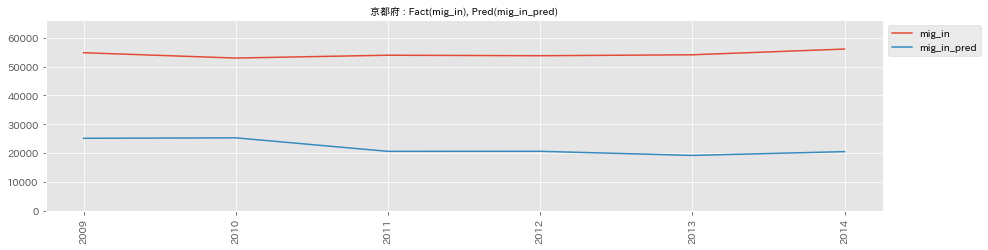

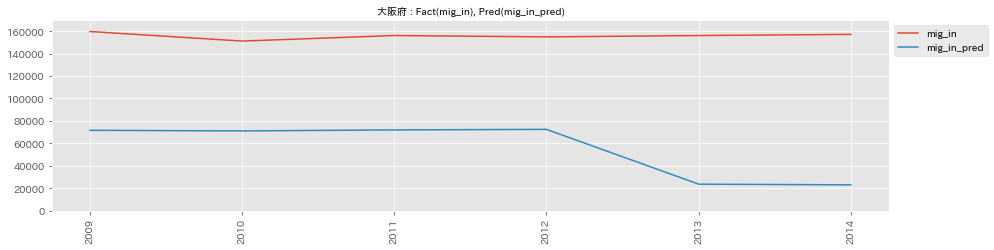

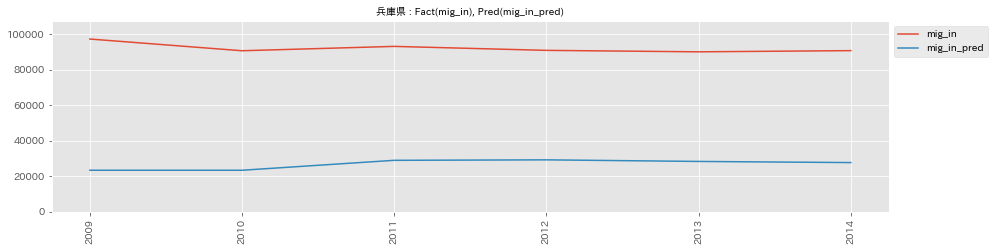

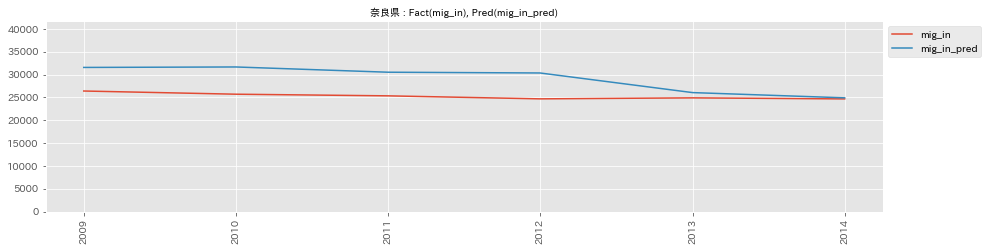

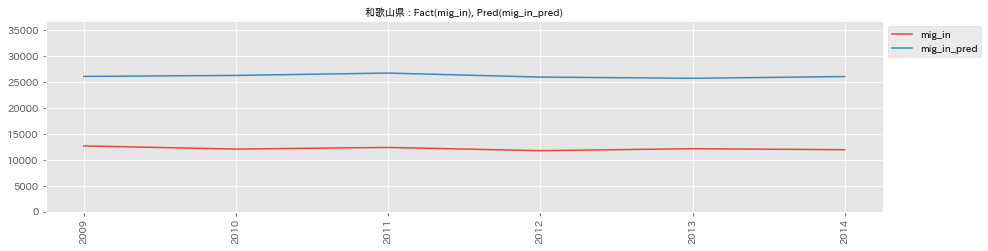

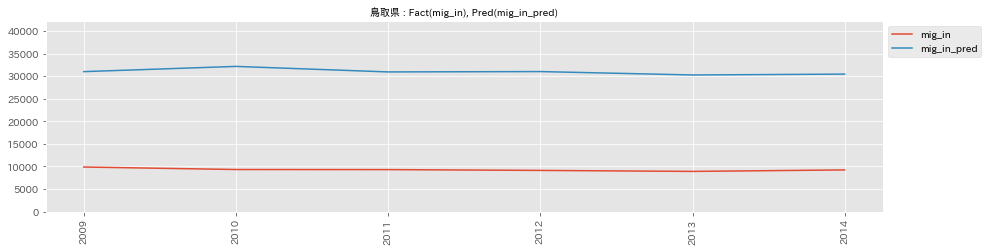

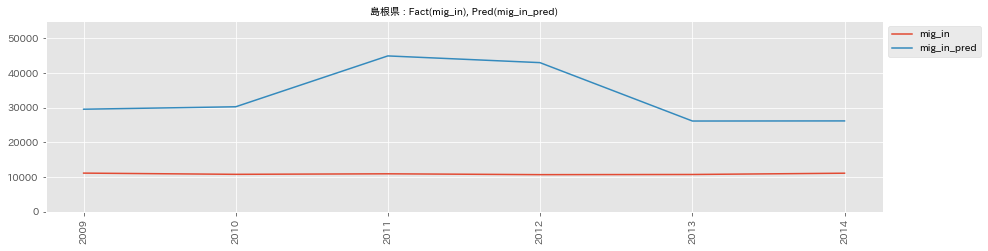

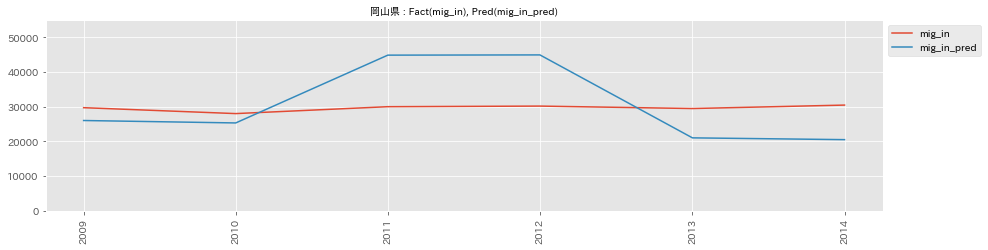

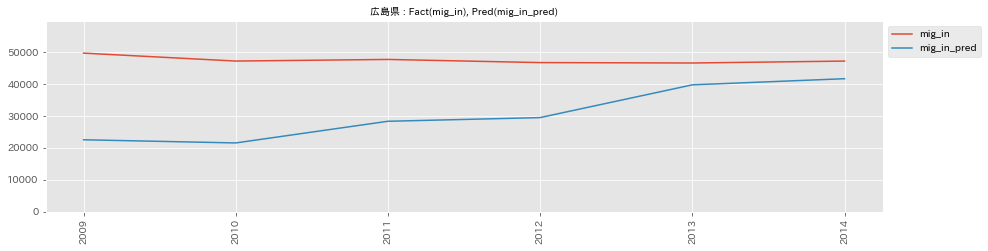

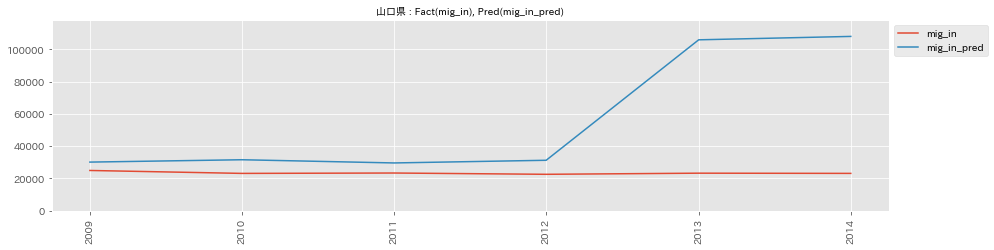

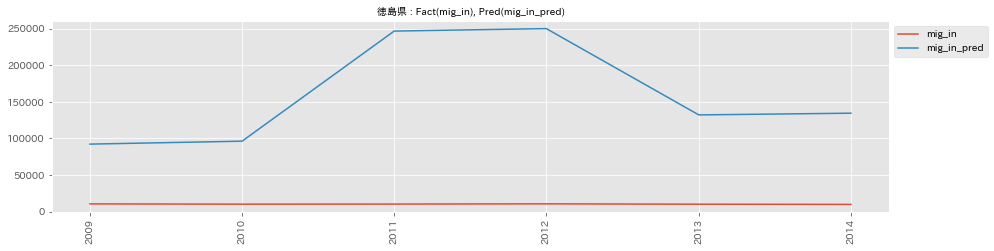

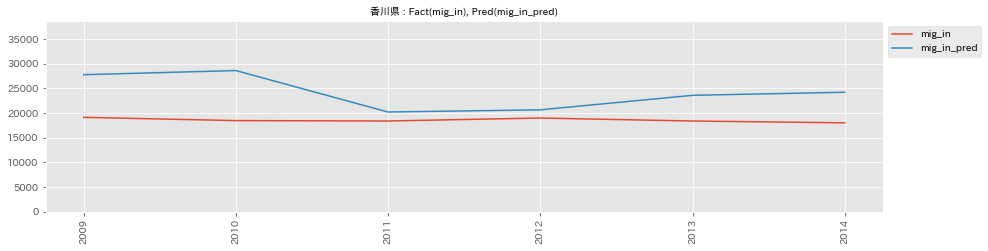

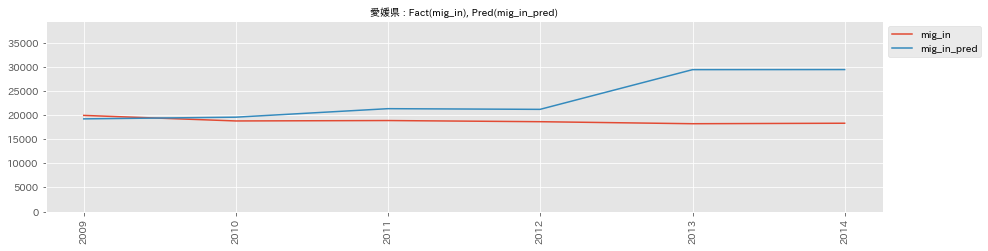

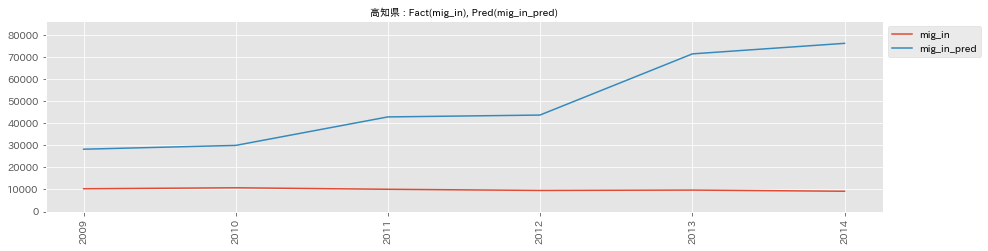

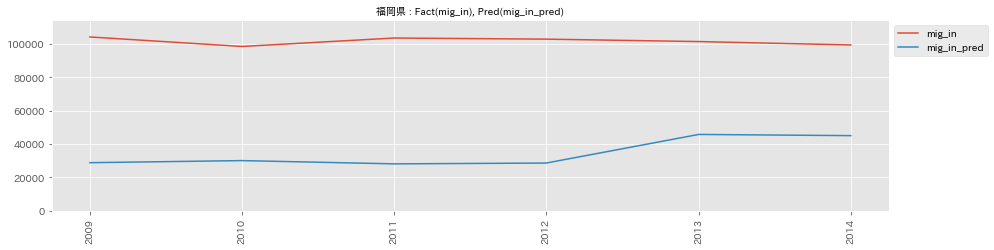

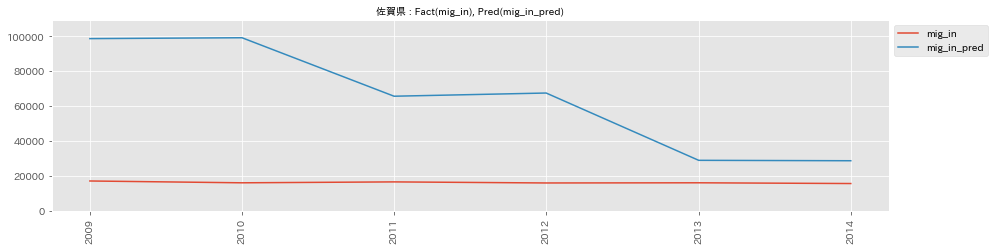

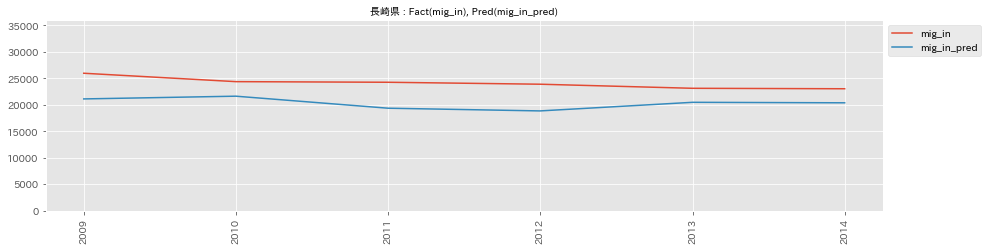

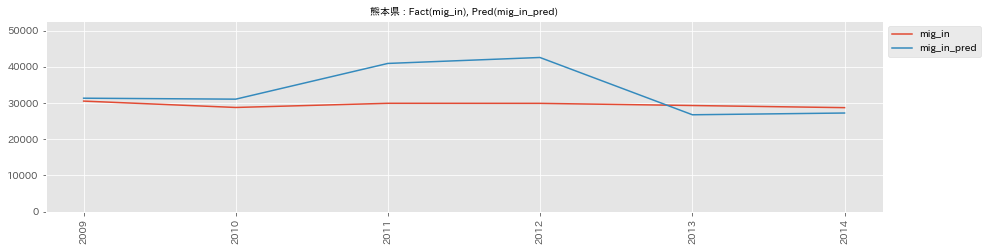

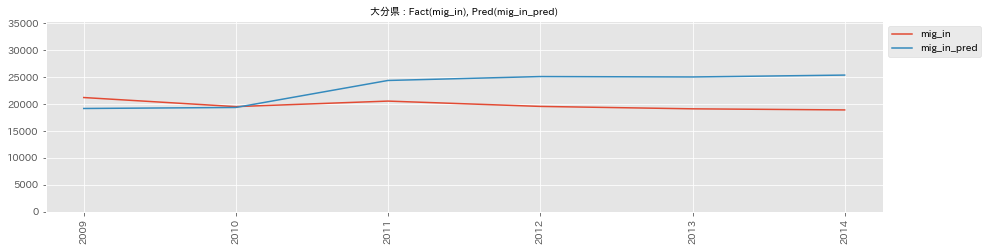

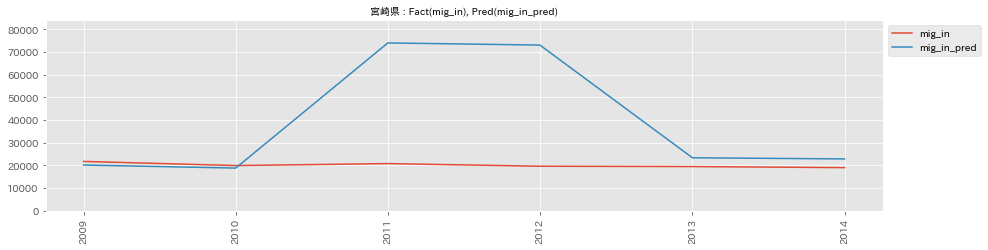

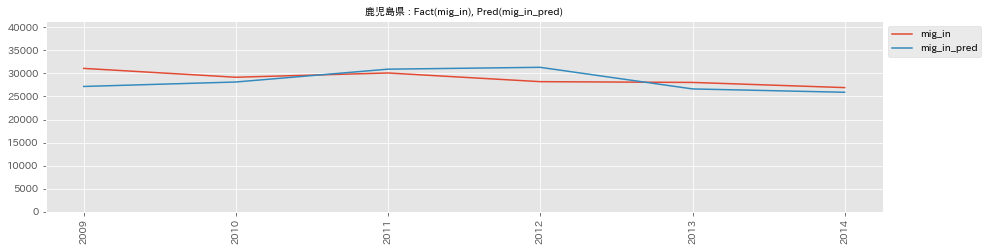

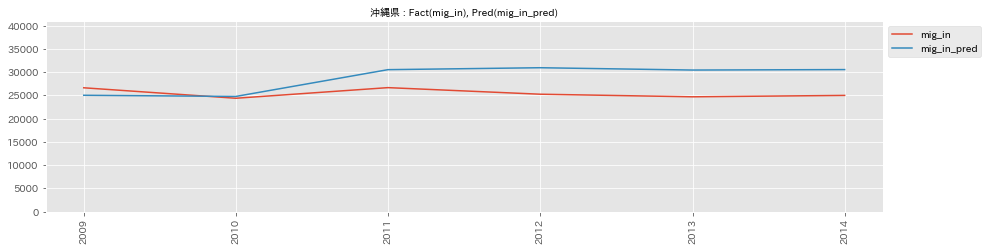

In [13]:
### 予測データの確認(可視化)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'IPAexGothic'
for prefecture in df_pred['prefecture'].unique():
    df_tmp = df_pred[df_pred['prefecture'] == prefecture]
    x = df_tmp['datetime']
    y1 = df_tmp['mig_in']
    y2 = df_tmp['mig_in_pred']
    fig = plt.figure(figsize=(15,3.5))
    ax = fig.add_subplot(111)
    ax.plot(x, y1)
    ax.plot(x, y2)
    plt.ylim(0, max(y1.max(), y2.max()) + 10000)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(prefecture + ' : Fact(mig_in), Pred(mig_in_pred)', fontsize=10)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()